In [1]:
import pandas as pd
import numpy as np
import kaggle
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings


kaggle.api.authenticate()
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
kaggle.api.dataset_download_files('altavish/boston-housing-dataset',path='csv_files',unzip=True)

In [3]:
df=pd.read_csv('csv_files/HousingData.csv')

In [4]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


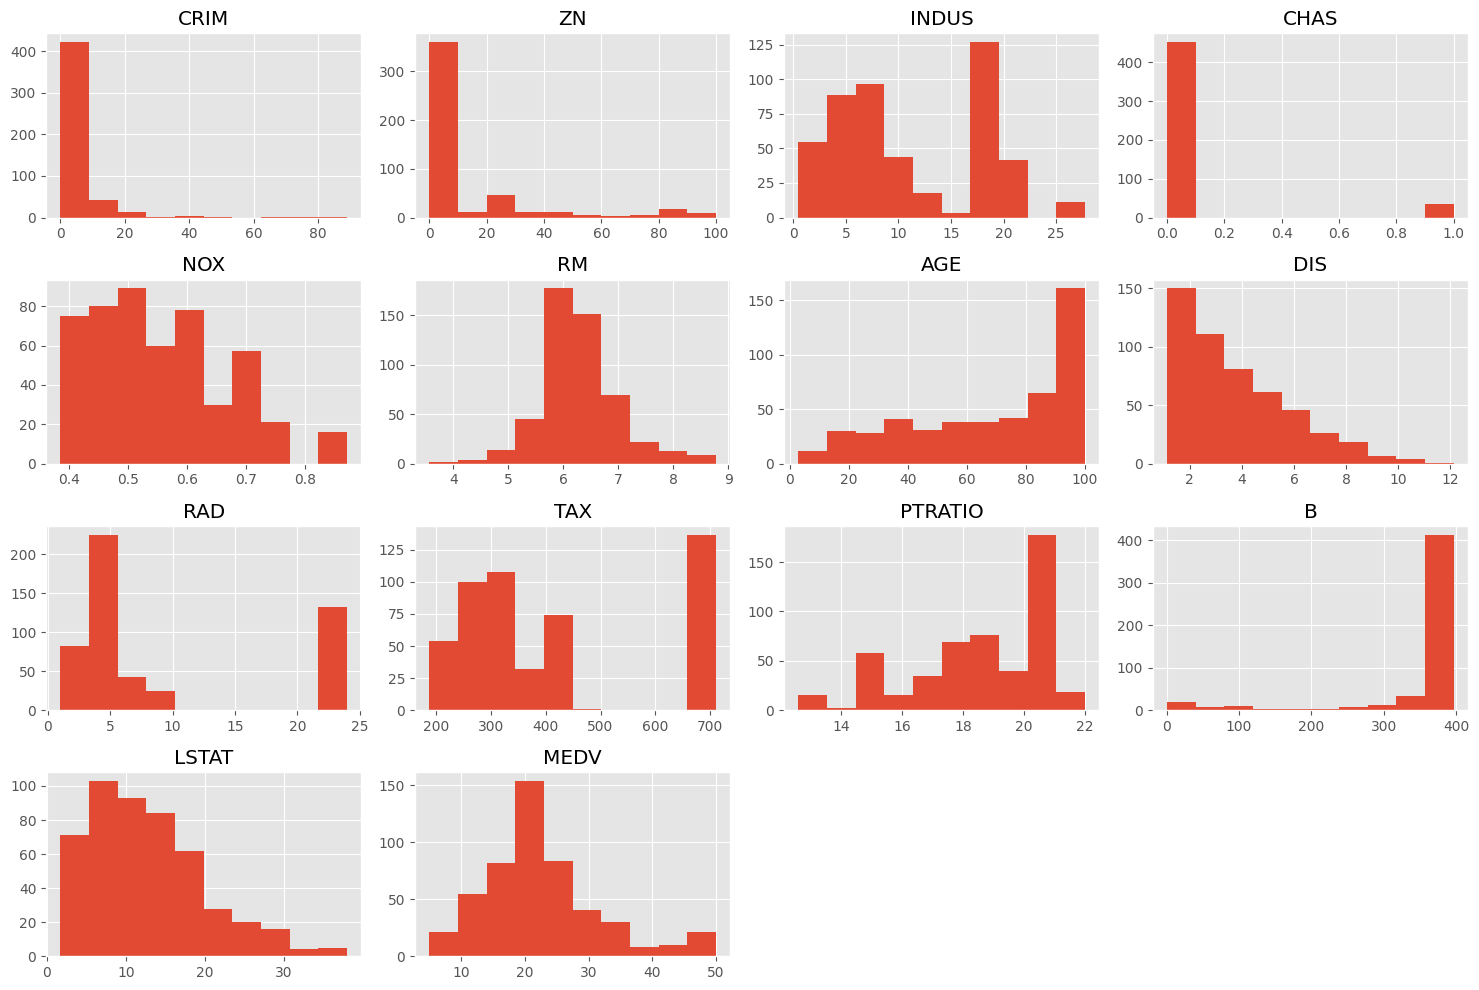

In [5]:
df.hist(figsize=(15,10))
plt.tight_layout()
plt.show()

In [6]:
df['MEDV'].value_counts().sort_values(ascending=False)
df=df[df['MEDV']!=50]

In [7]:
df.corr()['MEDV'].sort_values(ascending=False)

MEDV       1.000000
RM         0.686634
ZN         0.412684
DIS        0.368813
B          0.364928
CHAS       0.080537
CRIM      -0.451876
RAD       -0.476296
AGE       -0.494772
PTRATIO   -0.518641
NOX       -0.524451
TAX       -0.572442
INDUS     -0.600605
LSTAT     -0.758934
Name: MEDV, dtype: float64

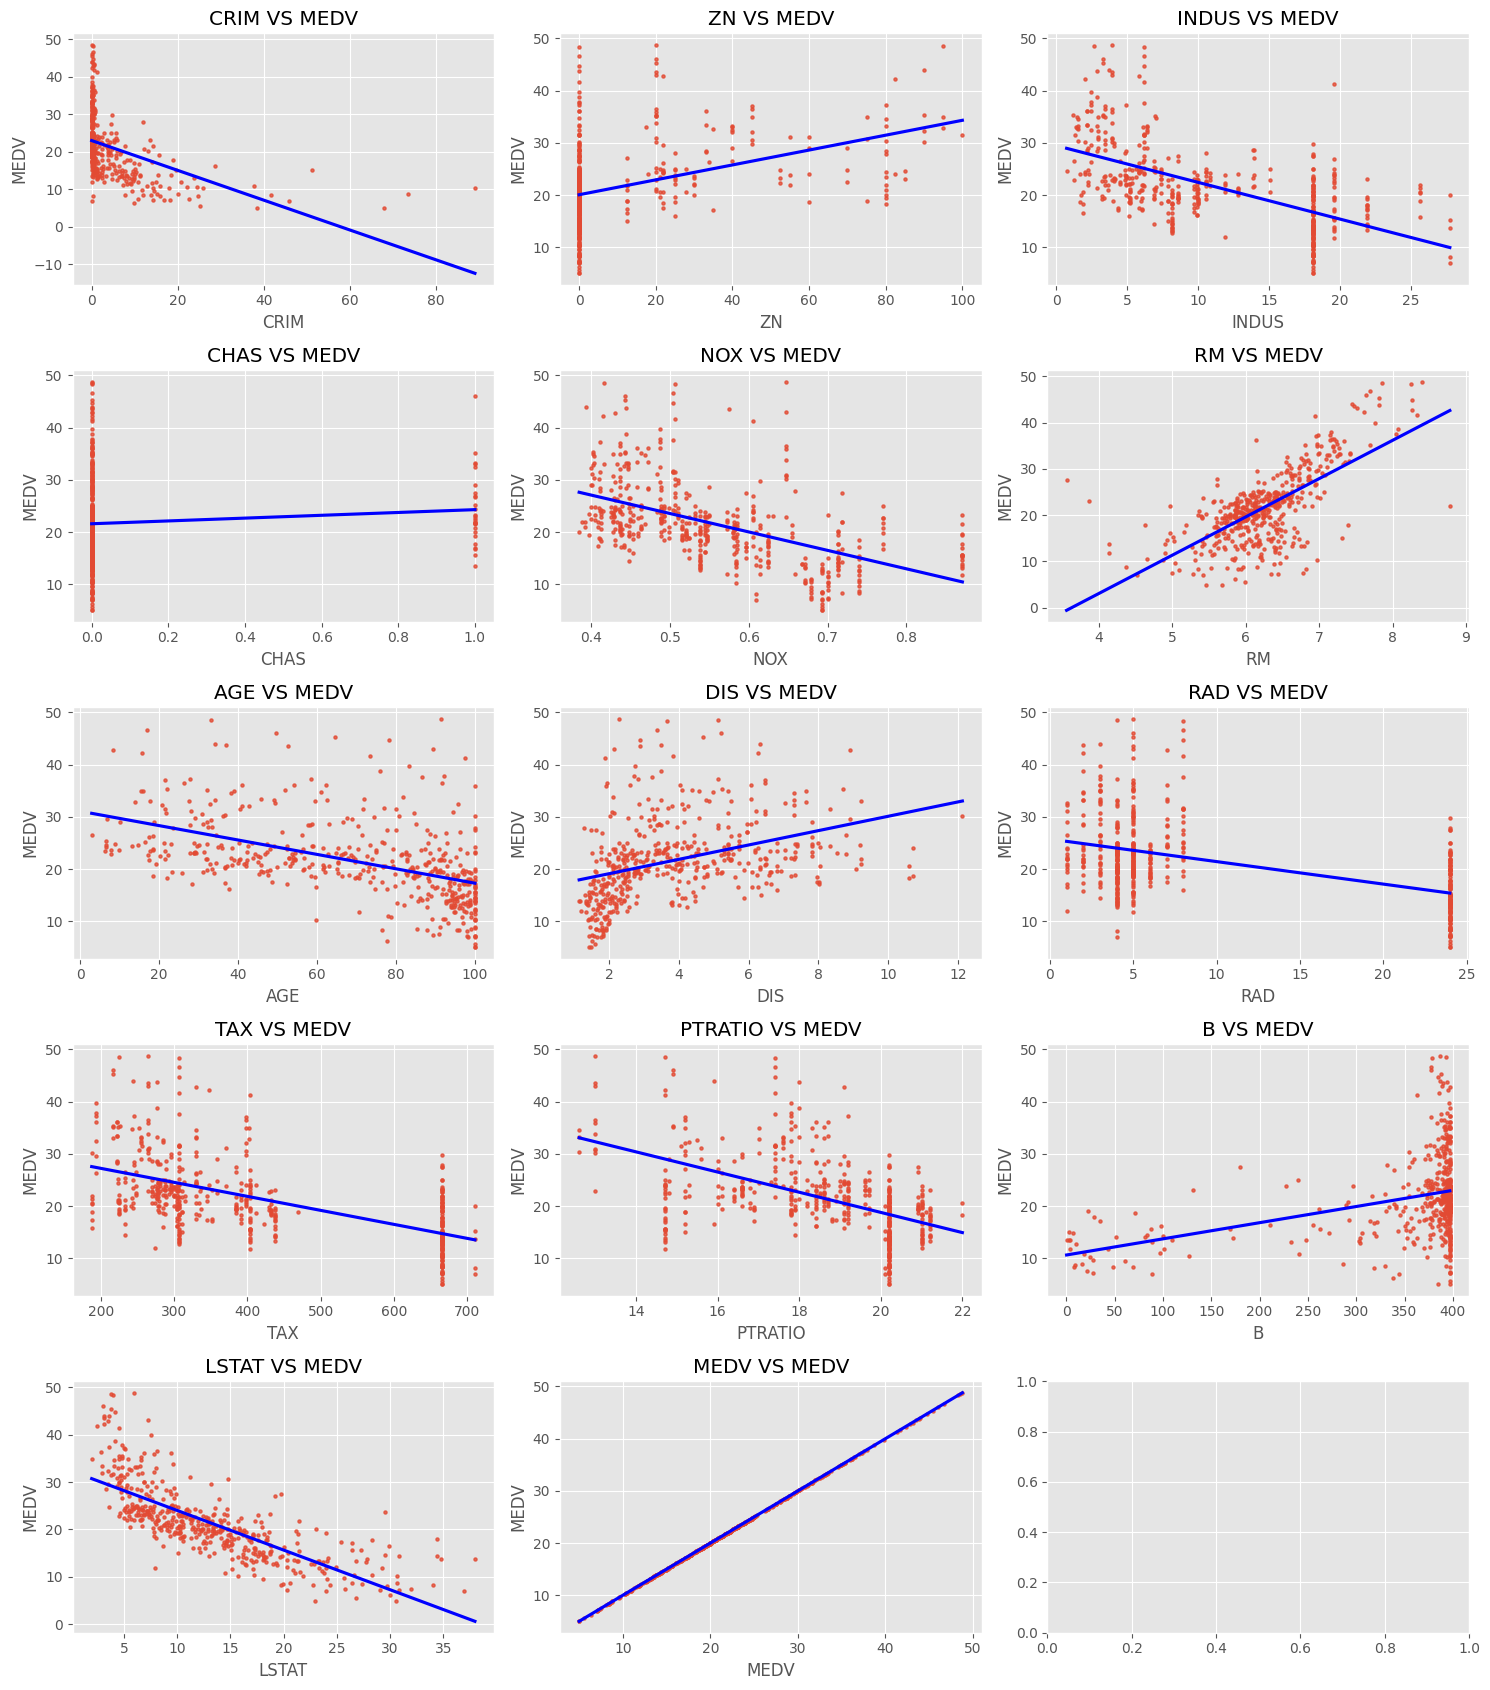

In [8]:
fig,axes=plt.subplots(5,3,figsize=(15,17))
cols=df.select_dtypes([int,float])

for col,ax in zip(cols,axes.ravel()):
    sns.regplot(df,x=col,y='MEDV',line_kws={"color": "blue"},scatter_kws={"s": 5},ax=ax,ci=None)
    ax.set_title(f'{col} VS MEDV')
plt.tight_layout()
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

X=df.drop(columns='MEDV')
y=df['MEDV']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV



pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler()),
    ('model',XGBRegressor())
])

param_grid={
    'model__n_estimators':[100,200,500,1000],
    'model__learning_rate':[0.01,0.03,0.1,0.15],
    'model__max_depth':[3,5,7,9]
}


grid_search_cv = GridSearchCV(pipeline, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search_cv.fit(X_train, y_train)

best_model=grid_search_cv.best_estimator_
print(grid_search_cv.best_estimator_)
print(grid_search_cv.best_score_)
print(grid_search_cv.best_params_)


Fitting 3 folds for each of 64 candidates, totalling 192 fits
Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.03,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_ch

In [11]:
train_prediction=best_model.predict(X_train)
test_prediction=best_model.predict(X_test)

In [12]:
from sklearn import metrics
r2_train=metrics.r2_score(train_prediction,y_train)
r2_test=metrics.r2_score(test_prediction,y_test)
mae_train=metrics.mean_absolute_error(train_prediction,y_train)
mae_test=metrics.mean_absolute_error(test_prediction,y_test)
rmse_train=metrics.mean_squared_error(train_prediction,y_train,squared=False)
rmse_test=metrics.mean_squared_error(test_prediction,y_test,squared=False)
train_scores={'R2_train':r2_train,'MAE_train':mae_train,'RMSE_train':rmse_train}
test_scores={'R2_test':r2_test,'MAE_test':mae_test,'RMSE_test':rmse_test}
print(train_scores)
print(test_scores)

{'R2_train': 0.9740867242624623, 'MAE_train': 0.9362583977835519, 'RMSE_train': 1.2219000341799842}
{'R2_test': 0.8688141743226574, 'MAE_test': 1.831658070428031, 'RMSE_test': 2.6928205960600473}


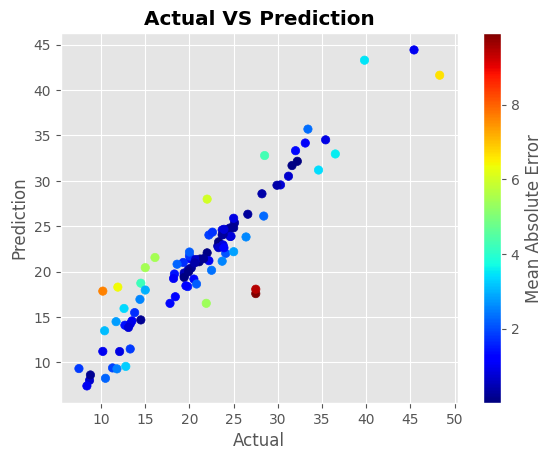

In [13]:
#plt.figure(figsize=(15,5))
plt.scatter(x=y_test,y=test_prediction,c=(y_test-test_prediction).abs(),cmap='jet')
plt.title('Actual VS Prediction',fontweight='bold')
plt.colorbar().set_label('Mean Absolute Error')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

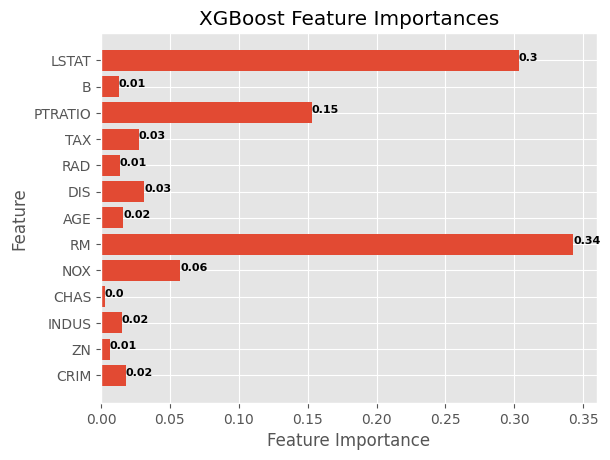

In [14]:
weights= best_model.named_steps['model'].feature_importances_
features=X_train.columns

plt.barh(y=features, width=weights)
for i in range(len(features)):
    plt.text(weights[i],i,weights[i].round(2),fontweight='bold',size=8)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importances')
plt.show()

In [15]:
test=X_test
test['Actual']=y_test
test['Prediction']=test_prediction

test['Error']=test['Actual']-test['Prediction']

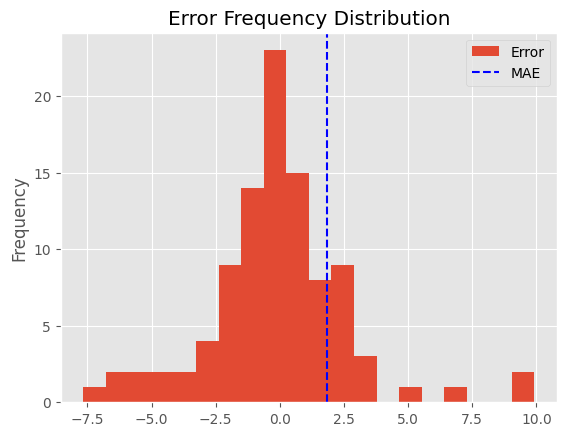

In [16]:
mae=test['Error'].abs().mean()
rmse=test['Error'].std()

test['Error'].plot.hist(bins=20)
plt.axvline(mae,ls='--',color='blue',label='MAE')
plt.title('Error Frequency Distribution')
plt.legend()
plt.show()